# Graph reconstruction in 3d 

In 3d there is no implemented filtered Back projection, hence we accomodate it 
by structuring the ECT to make the FBP easier. 
 


In [38]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import torchvision.transforms.functional as f


def cartesion_to_spherical(xyz):
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

np.random.seed(42)

NUM_STEPS=256
NUM_PTS = 15

def generate_thetas():
    v = []
    for theta in torch.linspace(0,2*torch.pi,8):
        for phi in torch.linspace(0,2*torch.pi,64):
            v.append(
                torch.tensor([
                    torch.sin(phi)*torch.cos(theta),
                    torch.sin(phi)*torch.sin(theta),
                    torch.cos(phi)
                ])
                )
    return torch.vstack(v).T

V = (torch.rand(size=(NUM_STEPS,3)) - 0.5)
V /= V.pow(2).sum(axis=1).sqrt().unsqueeze(1)

v = V.T


In [53]:
scale = 200
def compute_ect(x, v, ei=None):
    nh = x @ v
    lin = torch.linspace(-1, 1, NUM_STEPS).view(-1, 1, 1)
    ecc =  torch.nn.functional.sigmoid(scale * torch.sub(lin, nh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, nh)))
    ecc = ecc.sum(axis=1)
    if ei is not None:
        eh = nh[ei].mean(axis=0)
        eccedge = torch.nn.functional.sigmoid(scale * torch.sub(lin, eh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, eh)))
        eccedge = eccedge.sum(axis=1)
        ecc -= eccedge
    return ecc


# x = torch.tensor([
#     [0,0,0.0],
#     [0,-.7,0.5],
#     [0,.5,-.1],
# ])


x = torch.vstack(
    [
       .6 * torch.sin(
            torch.tensor(
                np.linspace(0, torch.pi * 2, NUM_PTS, endpoint=False),
                dtype=torch.float32,
            )
        ),
        .3 * torch.cos(
            torch.tensor(
                np.linspace(0, torch.pi * 2, NUM_PTS, endpoint=False),
                dtype=torch.float32,
            )
        ),
        torch.zeros_like(torch.linspace(0, torch.pi * 2, NUM_PTS))
    ]
    ).T


ei = torch.vstack([torch.zeros(NUM_PTS-1,dtype=torch.long),torch.arange(1,NUM_PTS,dtype=torch.long)])


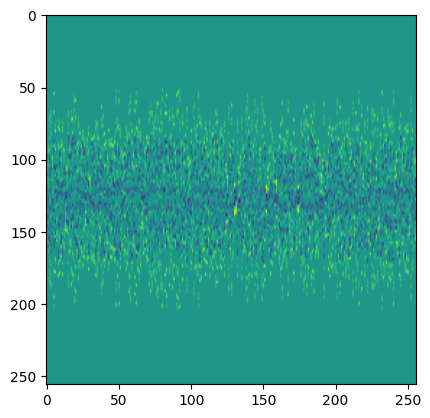

In [54]:
ect = compute_ect(x,v,ei=ei)

ect.shape
plt.imshow(ect)

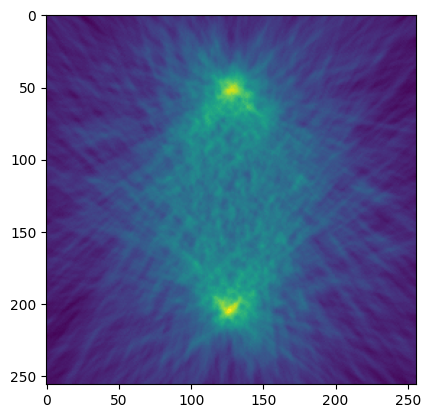

In [42]:
# ####################################################
# ### Reconstruct 3d using filtered backprojection.
# ####################################################

xg, yg ,zg = np.meshgrid(np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False), indexing='ij', sparse=True)

recon = torch.zeros(NUM_STEPS,NUM_STEPS,NUM_STEPS)

def calc_idx(theta,xg,yg,zg):
    heights = theta[0]*xg + theta[1]*yg + theta[2]*zg
    idx=((heights + 1)  * NUM_STEPS/2).long()+1
    idx[idx>NUM_STEPS-1]=NUM_STEPS-1
    return idx

i = 0
for theta,slice in zip(v.T,ect.T):
    i +=1    
    idx = calc_idx(theta,xg,yg,zg)
    reps = slice[idx]
    recon += reps
    # if i==3:
    #     recon += reps
    #     break



plt.imshow(recon[:,int(NUM_STEPS/2),:])

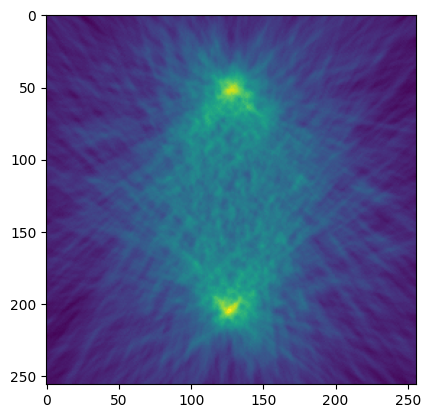

In [43]:

plt.imshow(recon[:,int(NUM_STEPS/2),:])

In [44]:
from scipy.ndimage import maximum_filter
recon_np = recon.numpy()
res = maximum_filter(recon_np,footprint=np.ones((5,5,5)))
mask = (recon_np == res)


In [50]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]
vals /=vals.max()
idx = np.where(vals>.8)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


pts = np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T

# Reconstruct Edges

In [ ]:
import itertools

recon_np *=-1
res = maximum_filter(recon_np,footprint=np.ones((5,5,5)))
mask = (recon_np == res)

idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]
vals /=vals.max()
idx = np.where(vals>.8)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


edge_pts = np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T

adj = np.zeros((len(pts),len(pts)))

for i in range(len(pts)):
    for j in range(len(pts)):
        adj[i,j] = np.linalg.norm()
